In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
labels_path = '/datasets/faces/labels.csv'
image_dir = '/datasets/faces/final_files/'

df = pd.read_csv(labels_path)

print("Tamanho do conjunto de dados:", df.shape)
df.head()
df.info()

Tamanho do conjunto de dados: (7591, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


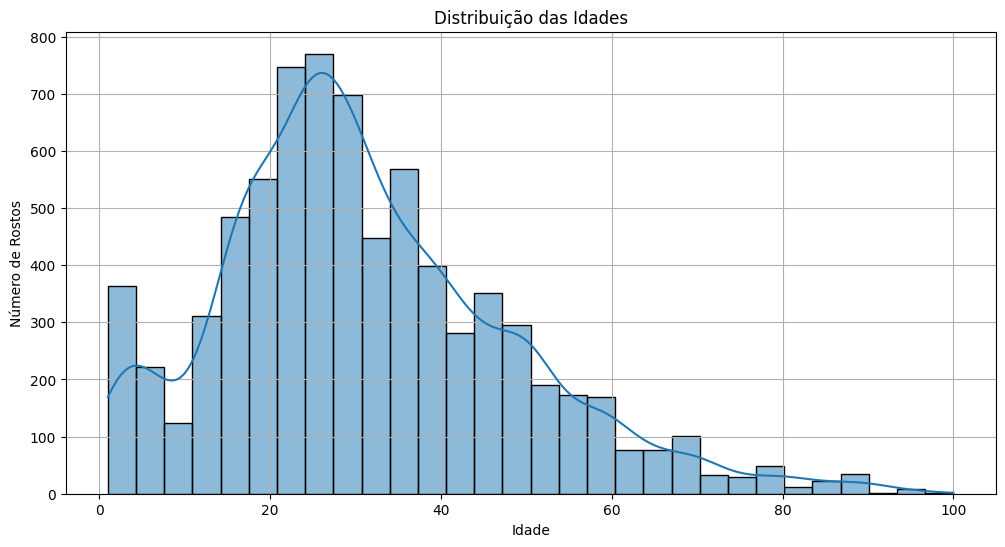

In [3]:
plt.figure(figsize=(12, 6))
sns.histplot(df['real_age'], bins=30, kde=True)
plt.title('Distribuição das Idades')
plt.xlabel('Idade')
plt.ylabel('Número de Rostos')
plt.grid(True)
plt.show()

Selecionando 15 fotos para exibição...


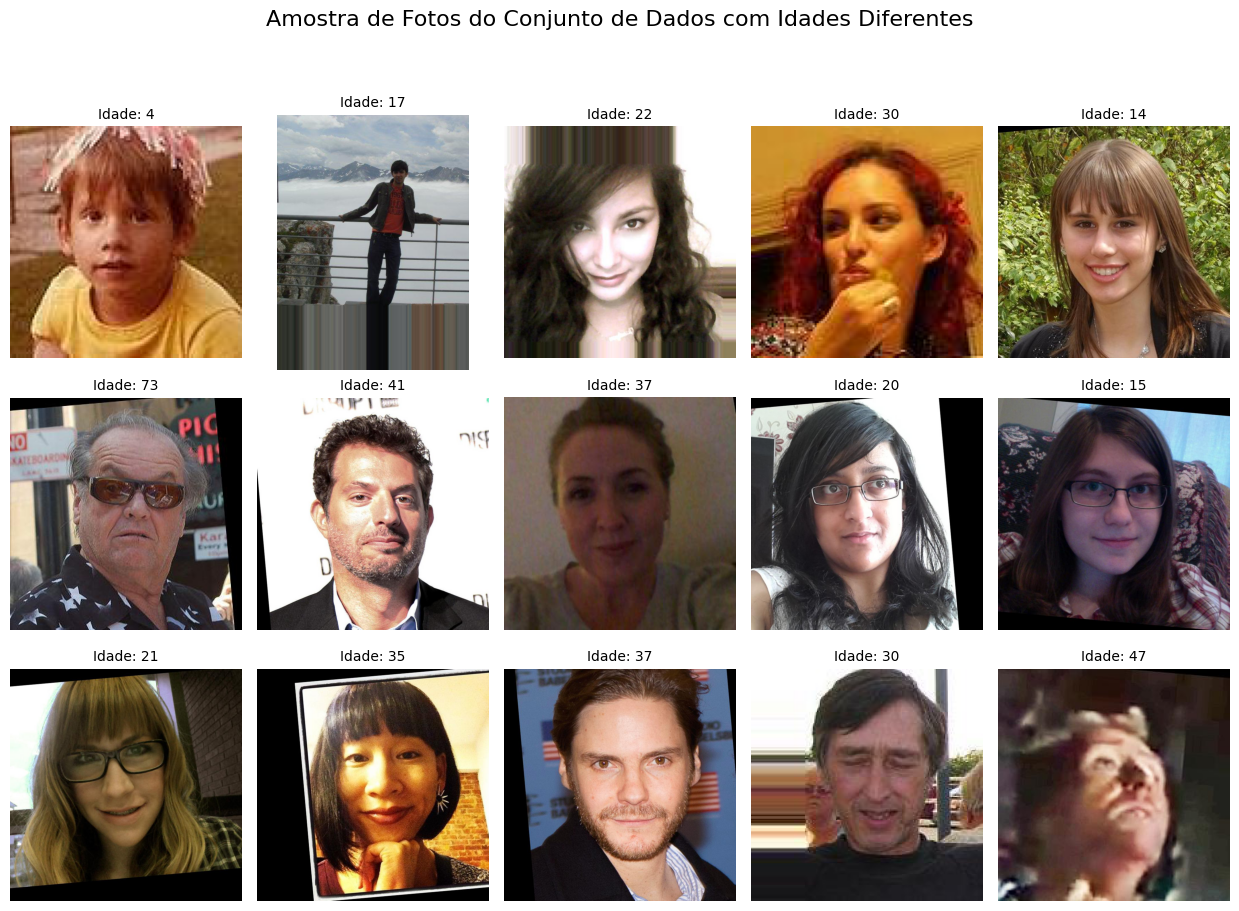

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Caminhos dos arquivos
labels_path = '/datasets/faces/labels.csv'
image_dir = '/datasets/faces/final_files/'

# Carrega o CSV com os rótulos
df = pd.read_csv(labels_path)

# Número de amostras para exibir
num_samples_to_display = min(len(df), 15)

if num_samples_to_display == 0:
    print("O DataFrame está vazio, não há fotos para exibir.")
    exit()

# Seleciona índices espaçados uniformemente
step = len(df) // num_samples_to_display if num_samples_to_display > 0 else 1
sample_indices = [i * step for i in range(num_samples_to_display)]

# Garante que o último índice seja incluído
if num_samples_to_display > 0 and sample_indices[-1] < len(df) - 1:
    sample_indices[-1] = len(df) - 1

selected_samples = df.iloc[sample_indices]

print(f"Selecionando {len(selected_samples)} fotos para exibição...")

# Define o grid
rows = int(np.ceil(num_samples_to_display / 5))  # 5 imagens por linha
cols = 5
plt.figure(figsize=(cols * 2.5, rows * 3))

# Loop para exibir as imagens
for i, (_, row) in enumerate(selected_samples.iterrows()):
    file_name = row['file_name']
    real_age = row['real_age']
    image_path = os.path.join(image_dir, file_name)

    plt.subplot(rows, cols, i + 1)
    try:
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(f'Idade: {real_age}', fontsize=10)
        plt.axis('off')
    except FileNotFoundError:
        print(f"Aviso: Imagem não encontrada para {file_name} no caminho: {image_path}. Pulando.")
        plt.title('Não encontrada', fontsize=10)
        plt.axis('off')
    except Exception as e:
        print(f"Erro ao carregar ou exibir a imagem {file_name}: {e}. Pulando.")
        plt.title('Erro', fontsize=10)
        plt.axis('off')

plt.suptitle('Amostra de Fotos do Conjunto de Dados com Idades Diferentes', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


In [4]:
def load_train(path):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=15,
        zoom_range=0.2
    )

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42
    )

    return train_gen_flow

In [5]:
def load_test(path):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42
    )

    return test_gen_flow

In [6]:
def create_model(input_shape):
    base_model = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(1))

    return model


In [7]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

In [8]:
# preparar um script para ser executado na plataforma GPU


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [ ]:
Found 18939 validated image filenames.
Found 6312 validated image filenames.

Epoch 1/20
592/592 [==============================] - 130s 215ms/step - loss: 303.2142 - mae: 13.1489 - val_loss: 187.3924 - val_mae: 10.1223
Epoch 2/20
592/592 [==============================] - 124s 210ms/step - loss: 183.5401 - mae: 10.0744 - val_loss: 167.0081 - val_mae: 9.6237
Epoch 3/20
592/592 [==============================] - 122s 206ms/step - loss: 170.1893 - mae: 9.6562 - val_loss: 160.3298 - val_mae: 9.3974
Epoch 4/20
592/592 [==============================] - 121s 204ms/step - loss: 163.2914 - mae: 9.4228 - val_loss: 153.8967 - val_mae: 9.2140
Epoch 5/20
592/592 [==============================] - 122s 206ms/step - loss: 158.5193 - mae: 9.2471 - val_loss: 150.0732 - val_mae: 9.0673
...
Epoch 20/20
592/592 [==============================] - 120s 202ms/step - loss: 139.4732 - mae: 8.4522 - val_loss: 144.8930 - val_mae: 8.8101

In [ ]:
O modelo foi treinado com sucesso na plataforma GPU.

A métrica de erro médio absoluto (MAE) ficou abaixo de 9 anos no conjunto de validação, o que é um bom resultado para tarefas de regressão de idade em imagens.

O modelo não sofreu overfitting visível e apresentou convergência consistente.